# Notes on Paper

- Claim 1: bidirectional pre-training is important for language representations
- Claim 2: pre-trained representations reduce the need for many heavily-engineered taskspecific architectures
  - achieves state-of-the-art performance on a large suite of sentence-level and token-level tasks, outperforming many task-specific architectures.

### Architecture

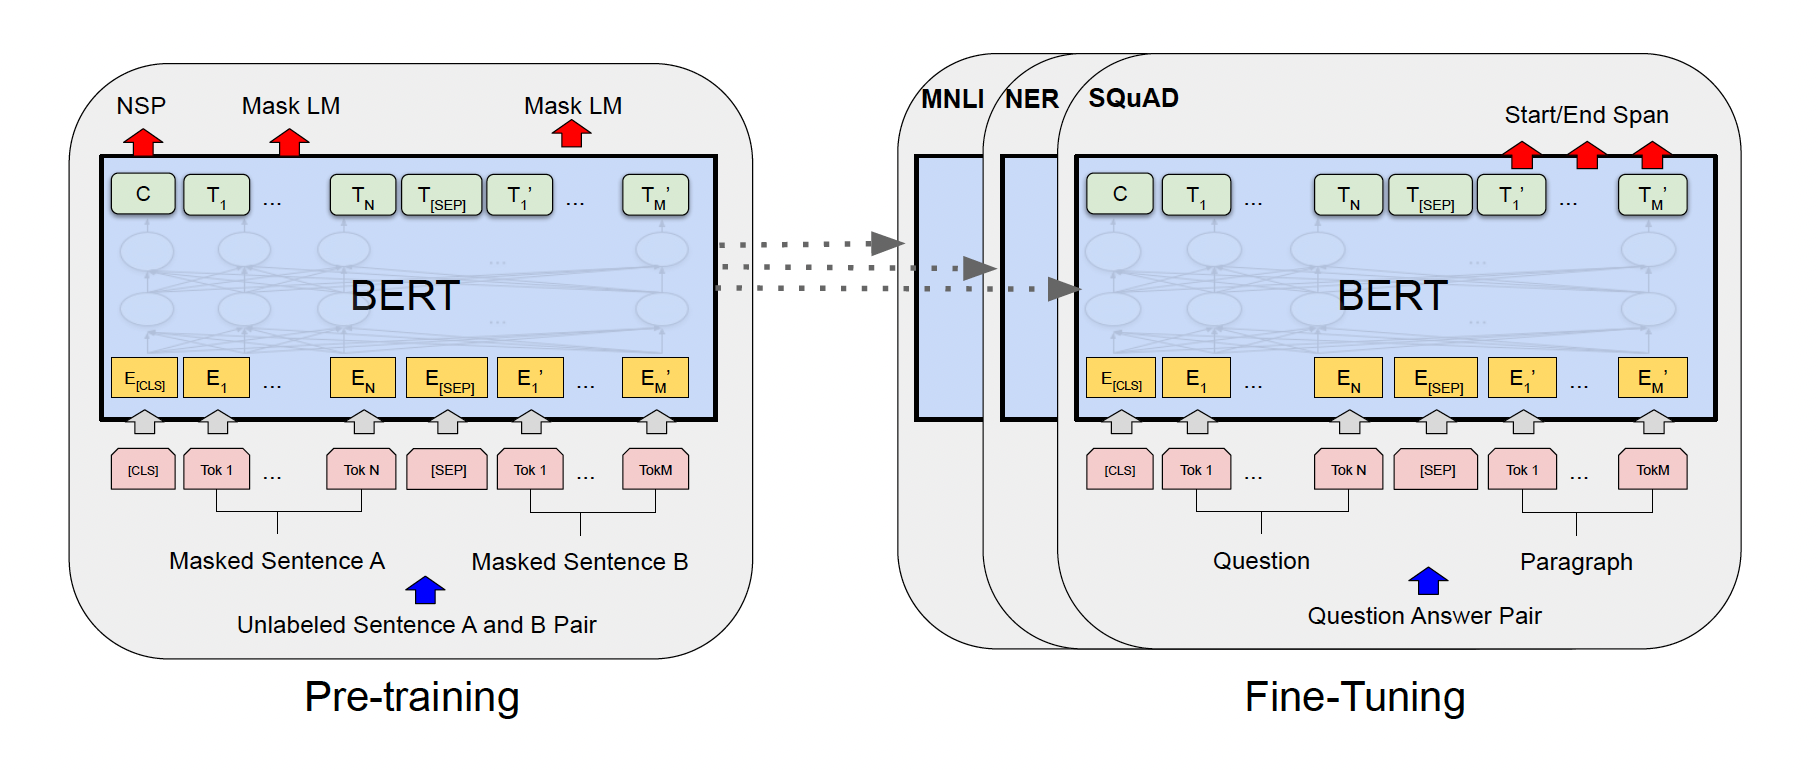æ
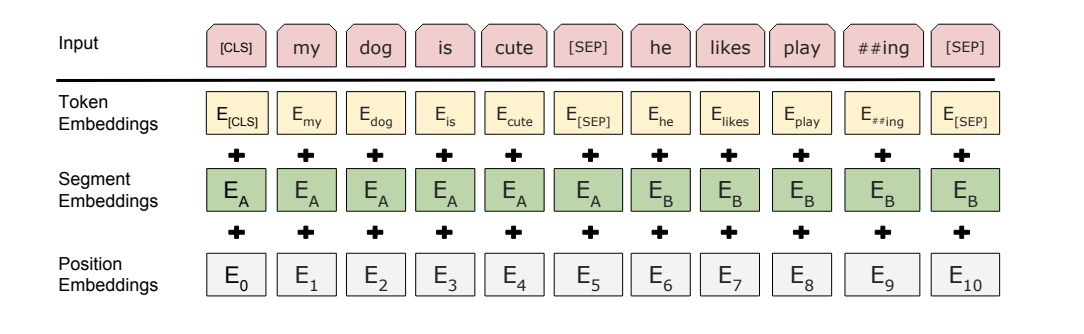

#### Details

- BERT-tiny has two layers and 128 heads
- bidirectional self-attention (e.g. full self-attention matrix?)
- For tiny bert:
  - 2 Transformer blocks with bidirectional self-attention and 128 heads

### Training

- pretokenize full dataset
- in training:
  - sample 512 consecutive tokens
  -

## Questions

- ChatGPT claims: "Transformers are not inherently aware of the sequential order of the tokens". Why?
  - What would happen if you pre-train it without the positional embedding?
  - I thought that the arrangement of the attention operation itself was enough to have positional encodings.
- How does the extension from 128 to 512 tokens during pre-training work?
- How many different masks are used on the same sentence pair during pre-training?
  - Is it like 2 for loops where one loops over the sequences and the other loops over the masks?
- One inference mode is "unmasking"
  - What do you have to do to run BERT in inference for this task?
- What's the output of BERT?
- How is the loss in BERT calculated?
  - first, a linear layer transforms the final mask embedding in question into a vector of size vocab
  - second, the vector is softmaxed
  - third, cross entropy is used to calculate the loss


In [1]:
from datasets import load_dataset

dataset = load_dataset("noanabeshima/TinyStoriesV2")

/Users/timon/.pyenv/versions/3.10.2/envs/dldl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
import torch
from torch import nn
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")


class TokenEmbedding(nn.Module):

    def __init__(self, config):
        super(TokenEmbedding, self).__init__()
        self.token_embedding = nn.Embedding(
            len(tokenizer), embedding_dim=config["hidden_size"]
        )

    def forward(self, x):
        return self.token_embedding(x)


class SegmentEmbedding(nn.Module):

    def __init__(self, config):
        super(SegmentEmbedding, self).__init__()
        self.segment_embedding = nn.Embedding(2, embedding_dim=config["hidden_size"])

    def forward(self, x):
        return self.segment_embedding(x)


# TODO: check transformer paper for alternative positional embeddings
class PositionalEmbedding(nn.Module):

    def __init__(self, config):
        super(PositionalEmbedding, self).__init__()
        self.embedding = nn.Embedding(
            config["max_position_embeddings"], config["hidden_size"]
        )

    def forward(self, x):
        return self.embedding(x)


class BERTtiny(nn.Module):

    def __init__(self, config):
        super(BERTtiny, self).__init__()
        self.tok_emb = TokenEmbedding(config)
        self.seg_emb = SegmentEmbedding(config)
        self.pos_emb = PositionalEmbedding(config)
        self.blocks = nn.ModuleList(
            [
                nn.TransformerEncoderLayer(
                    d_model=config["hidden_size"],
                    nhead=config["num_attention_heads"],
                    activation=config["hidden_act"],
                    dim_feedforward=config["intermediate_size"],
                    dropout=config["hidden_dropout_prob"],
                ),
            ]
            * config["num_hidden_layers"]
        )
        self.head = nn.Linear(config["hidden_size"], len(tokenizer))

    def forward(self, input_ids, token_type_ids, **kwargs):
        x = (
            self.tok_emb(input_ids)
            + self.seg_emb(token_type_ids)
            + self.pos_emb(torch.arange(input_ids.size(1)))
        )
        for block in self.blocks:
            x = block(x)

        x = self.head(x)
        return x

/Users/timon/.pyenv/versions/3.10.2/envs/dldl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [79]:
config = {
    "hidden_size": 128,
    "hidden_act": "gelu",
    "initializer_range": 0.02,  # TODO
    "vocab_size": 30522,
    "hidden_dropout_prob": 0.1,
    "num_attention_heads": 2,
    "type_vocab_size": 2,
    "max_position_embeddings": 512,
    "num_hidden_layers": 2,
    "intermediate_size": 512,
    "attention_probs_dropout_prob": 0.1,
}

model = BERTtiny(config)

tokens = tokenizer("Hello, this one sentence!", return_tensors="pt")

print(tokens)

res = model(**tokens)

res.shape

TypeError: TokenEmbedding.__init__() missing 1 required positional argument: 'config'

In [18]:
from pprint import pprint

pprint(tokens)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,  6289,  2038, 20952,
          2004,  2094,  6904, 16150,  2546,  2004,  2094,  2004,  2094,  6904,
         17371,  7011, 17371,  2546,  2004,  2094,  2004,  2094,  6904, 16150,
          2004,  2094,  6904, 17371,  7011, 17371,  2546,   102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [13]:
from torchinfo import summary

summary(model, input_size=(1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
BERTtiny                                 [1, 128, 128]             --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [1, 128, 128]             --
│    │    └─MultiheadAttention: 3-1      [1, 128, 128]             66,048
│    │    └─Dropout: 3-2                 [1, 128, 128]             --
│    │    └─LayerNorm: 3-3               [1, 128, 128]             256
│    │    └─Linear: 3-4                  [1, 128, 2048]            264,192
│    │    └─Dropout: 3-5                 [1, 128, 2048]            --
│    │    └─Linear: 3-6                  [1, 128, 128]             262,272
│    │    └─Dropout: 3-7                 [1, 128, 128]             --
│    │    └─LayerNorm: 3-8               [1, 128, 128]             256
│    └─TransformerEncoderLayer: 2-2      [1, 128, 128]             (recursive)
│    │    └─MultiheadAttention: 3-9      [1, 128, 128]      

In [20]:
token_embedding = TokenEmbedding()

token_embedding(tokens["input_ids"]).shape

torch.Size([1, 38, 128])

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2717694
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 27629
    })
})

In [26]:
for el in dataset["train"]:
    print(el)
    print(len(el["text"]))
    break

{'text': 'Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.\nOne day, Ollie\'s mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his friend, the duck. "Hi, Ollie!" said the duck. "Hi, duck!" said Ollie. "I need to hurry and catch fish for my family."\nWhile Ollie was catching fish, he found a big shiny stone. He thought, "This is not a fish, but it is so pretty!" Ollie took the shiny stone home to show his family. They all looked at the shiny stone and smiled. The shiny stone made everyone happy, and they forgot about the fish for dinner.'}
661
